In [101]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle


In [102]:
class Data:
    def __init__(self):
        self.dataframe = pd.DataFrame([])

    def read(self, file_name: str):
        """Reads a CSV file into the dataframe."""
        if os.path.exists(file_name):
            self.dataframe = pd.read_csv(file_name)
            print(f"Data successfully read from {file_name}.")
        else:
            print(f"Error: The file {file_name} does not exist.")

    def check_null_values(self):
        """Checks for null values in the dataframe."""
        print("Null Values Before Cleaning:")
        print(self.dataframe.isnull().sum())

    def clean_data(self):
        """Removes null values from the dataframe."""
        initial_shape = self.dataframe.shape
        self.dataframe.dropna(inplace=True)
        final_shape = self.dataframe.shape
        print(f"Data cleaned: {initial_shape[0] - final_shape[0]} rows removed.")

    def normalize(self):
        """Normalizes numeric columns in the dataframe."""
        numeric_cols = self.dataframe.select_dtypes(include=['float64', 'int64']).columns
        scaler = MinMaxScaler()
        self.dataframe[numeric_cols] = scaler.fit_transform(self.dataframe[numeric_cols])
        print(f"Data normalized for columns: {numeric_cols.tolist()}")

    def visualize(self, y_label):
        """Plots graph for open stock values vs. date."""
        if 'Date' in self.dataframe.columns and y_label in self.dataframe.columns:
            self.dataframe['Date'] = pd.to_datetime(self.dataframe['Date'])
            plt.figure(figsize=(14, 7))
            sns.lineplot(data=self.dataframe, x='Date', y=y_label)
            plt.title('Open Stock Values vs. Date')
            plt.xlabel('Date')
            plt.ylabel(f'{y_label} Stock Value')
            plt.show()
        else:
            print(f"Dataframe does not contain 'Date' and '{y_label}' columns.")

    def print_head(self):
        """Prints the head of the dataframe."""
        print("Head of the DataFrame:")
        print(self.dataframe.head())

    def print_description(self):
        """Prints the description of the dataframe."""
        print("\nDescription of the DataFrame:")
        print(self.dataframe.describe())

In [103]:
data = Data()

In [104]:
data.read('TCS.NS.csv')

Data successfully read from TCS.NS.csv.


In [105]:
data.check_null_values()

Null Values Before Cleaning:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [106]:
data.clean_data()

Data cleaned: 0 rows removed.


In [107]:
data.print_head()

Head of the DataFrame:
         Date         Open         High          Low        Close  \
0  2019-06-10  2196.699951  2235.850098  2185.500000  2231.500000   
1  2019-06-11  2237.000000  2263.949951  2231.000000  2252.800049   
2  2019-06-12  2245.000000  2266.899902  2219.000000  2260.899902   
3  2019-06-13  2264.000000  2285.000000  2243.050049  2254.100098   
4  2019-06-14  2257.250000  2263.100098  2234.000000  2254.500000   

     Adj Close   Volume  
0  1998.796021  2080593  
1  2017.875610  3048937  
2  2025.130249  2404448  
3  2019.039551  3320916  
4  2019.397339  2131408  


In [108]:
data.print_description()


Description of the DataFrame:
              Open         High          Low        Close    Adj Close  \
count  1236.000000  1236.000000  1236.000000  1236.000000  1236.000000   
mean   3064.463430  3093.670908  3033.591594  3063.316787  2916.850763   
std     634.603886   636.386500   632.618888   635.053523   663.062893   
min    1559.699951  1685.449951  1506.050049  1636.349976  1512.796997   
25%    2323.250000  2355.625000  2298.700074  2327.499939  2162.927185   
50%    3234.650024  3265.550049  3209.699951  3232.825074  3099.229981   
75%    3505.250000  3538.224976  3481.649963  3511.849914  3392.574707   
max    4215.250000  4254.750000  4177.000000  4219.250000  4188.805176   

             Volume  
count  1.236000e+03  
mean   2.764506e+06  
std    1.694205e+06  
min    2.244050e+05  
25%    1.692840e+06  
50%    2.308534e+06  
75%    3.265513e+06  
max    1.983933e+07  


In [109]:
data.normalize()

Data normalized for columns: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


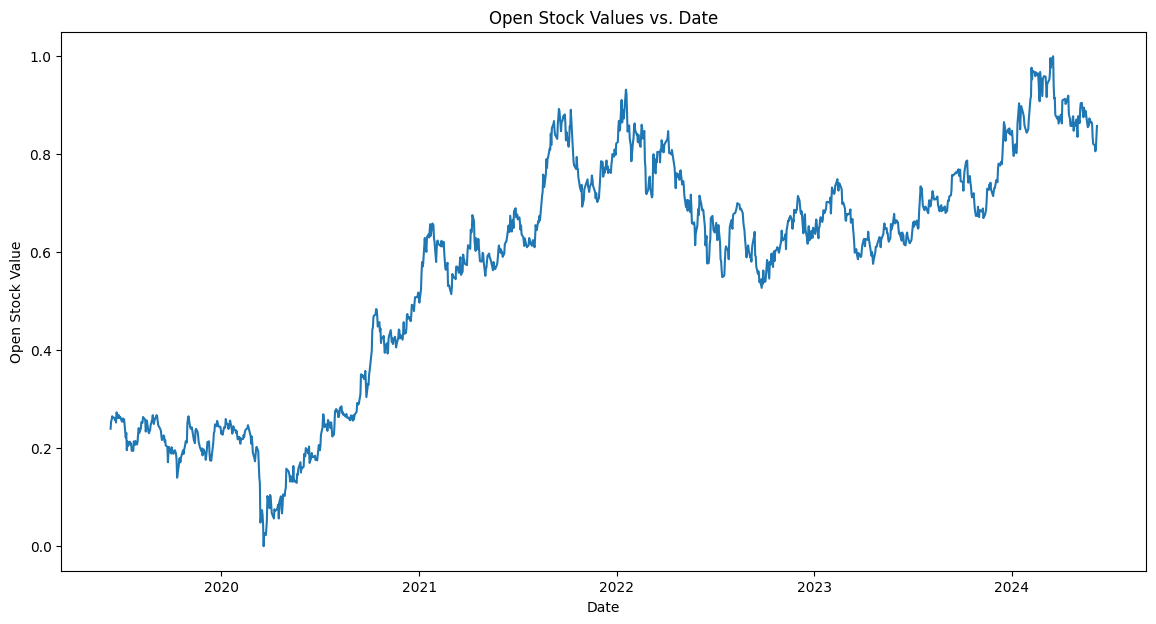

In [110]:
data.visualize('Open')

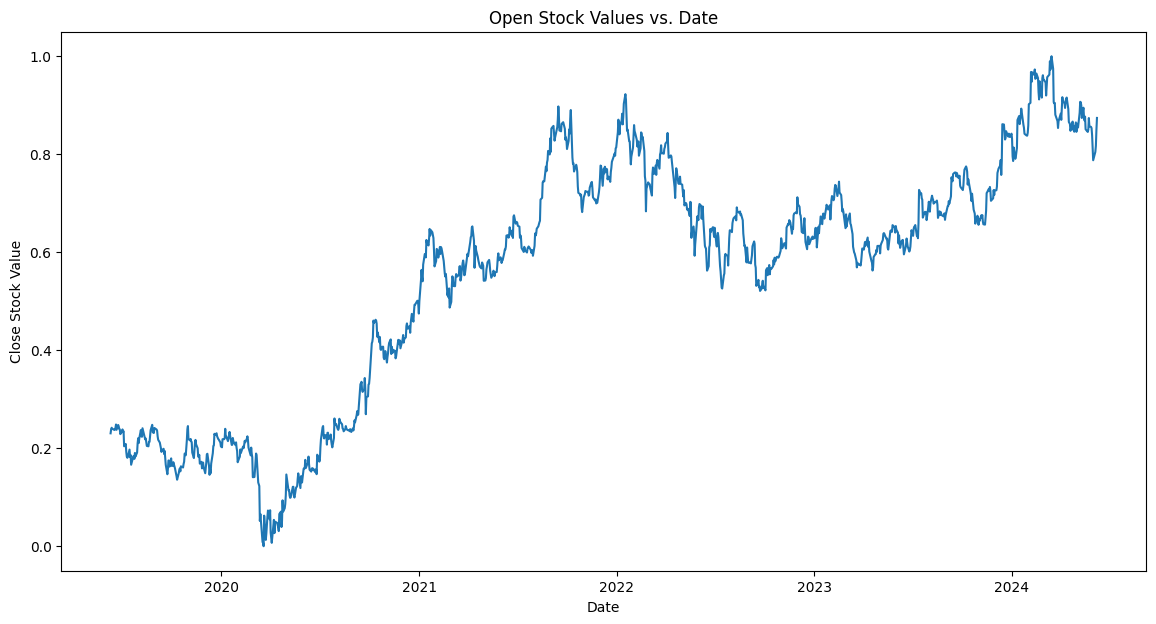

In [111]:
data.visualize('Close')

In [112]:
data.print_description()


Description of the DataFrame:
                                Date         Open         High          Low  \
count                           1236  1236.000000  1236.000000  1236.000000   
mean   2021-12-05 11:13:23.883494912     0.566649     0.548095     0.571909   
min              2019-06-10 00:00:00     0.000000     0.000000     0.000000   
25%              2020-09-07 18:00:00     0.287530     0.260840     0.296767   
50%              2021-12-06 12:00:00     0.630736     0.614992     0.637844   
75%              2023-03-01 06:00:00     0.732635     0.721121     0.739662   
max              2024-06-07 00:00:00     1.000000     1.000000     1.000000   
std                              NaN     0.238973     0.247689     0.236852   

             Close    Adj Close       Volume  
count  1236.000000  1236.000000  1236.000000  
mean      0.552467     0.524682     0.129498  
min       0.000000     0.000000     0.000000  
25%       0.267587     0.242948     0.074863  
50%       0.618094    

In [113]:
class LSTM_Trainer:
    def __init__(self, dataframe, scaler):
        self.dataframe = dataframe
        self.scaler = scaler

    def prepare_data(self, feature_col = 'Close', look_back = 60):
        """Prepare data for lstm"""
        data = self.dataframe[feature_col].values
        data = data.reshape(-1, 1)

        x = []
        y = []

        for i in range(len(data) - look_back):
            x.append(data[i:i + look_back])
            y.append(data[i + look_back])

        x, y = np.array(x), np.array(y)

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = False)
        return x_train, x_test, y_train, y_test.reshape(-1, 1)


    def build_and_train_lstm(self, feature_col = 'Close', look_back = 60, epochs = 40, batch_size = 32):
        """Build and train the lstm model"""
        x_train, x_test, y_train, y_test = self.prepare_data(feature_col, look_back)

        model = Sequential()
        model.add(LSTM(units = 50, return_sequences = True, input_shape = (look_back, 1)))
        model.add(LSTM(units = 50))
        model.add(Dense(1))

        model.compile(optimizer = 'adam', loss = 'mean_squared_error')

        model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (x_test, y_test))

        self.model = model
        self.x_test = x_test
        self.y_test = y_test

    def predict_and_plot(self):
        """Make predictions and plot the results"""
        predictions = self.model.predict(self.x_test)
        predictions = predictions.reshape(-1, 1)
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.scaler.fit(self.dataframe['Close'].values.reshape(-1, 1))
        predictions = self.scaler.inverse_transform(predictions)
        actual = self.scaler.inverse_transform(self.y_test.reshape(-1, 1))

        plt.figure(figsize = (14, 7))
        plt.plot(actual, label = 'Actual Stock Price')
        plt.plot(predictions, label = 'Predicted Stock Price')
        plt.title('Actual vs Predicted Stock Prices')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

    def evaluate_model(self):
        """Evaluating the model"""
        predictions = self.model.predict(self.x_test)
        predictions = self.scaler.inverse_transform(predictions)
        actual = self.scaler.inverse_transform(self.y_test.reshape(-1, 1))

        mse = mean_squared_error(actual, predictions)
        mae = mean_absolute_error(actual, predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(actual, predictions)

        print(f"Mean Squared Error: {mse}")
        print(f"Mean Absolute Error: {mae}")
        print(f"Root Mean Squared Error: {rmse}")
        print(f"R-squared: {r2}")

In [114]:

scaler = MinMaxScaler(feature_range=(0, 1))

scaler.fit(data.dataframe['Close'].values.reshape(-1, 1))

trainer = LSTM_Trainer(data.dataframe, scaler)

In [115]:

x_train, x_test, y_train, y_test = trainer.prepare_data()

In [116]:

trainer.build_and_train_lstm()

Epoch 1/40
30/30 [==============================] - 7s 96ms/step - loss: 0.0393 - val_loss: 0.0019
Epoch 2/40
30/30 [==============================] - 3s 100ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 3/40
30/30 [==============================] - 2s 60ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 4/40
30/30 [==============================] - 2s 59ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 5/40
30/30 [==============================] - 2s 57ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 6/40
30/30 [==============================] - 2s 59ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 7/40
30/30 [==============================] - 2s 59ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 8/40
30/30 [==============================] - 2s 69ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 9/40
30/30 [==============================] - 3s 103ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 10/40
30/30 [==============================] - 2s 58ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1

8/8 [==============================] - 1s 17ms/step


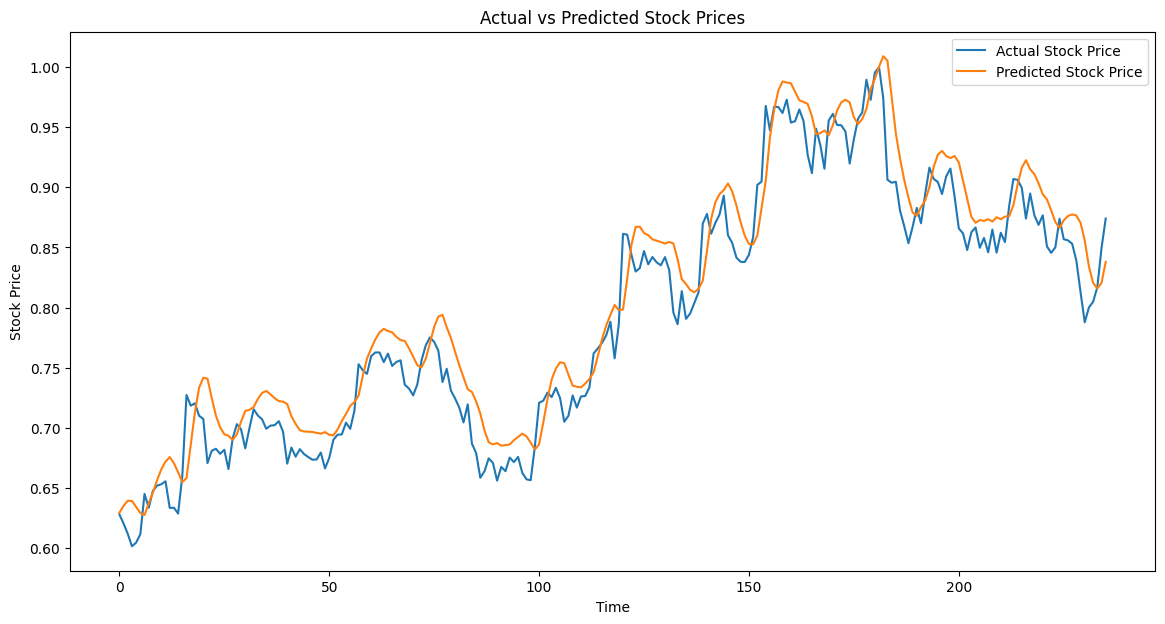

In [117]:

trainer.predict_and_plot()

In [118]:
trainer.evaluate_model()

8/8 [==============================] - 0s 30ms/step
Mean Squared Error: 0.0008069485334250492
Mean Absolute Error: 0.023394897205898352
Root Mean Squared Error: 0.028406839553618935
R-squared: 0.9230632550893608


In [133]:
with open('trained_model.pkl', 'wb') as f:
    pickle.dump(trainer.model, f)